# Advanced Lane Finding

Goal of this project is to detect lanes inside a video, using advanced image processing techniques such as color transformation, perspective transform (birds eye transform), gradients and thresholding, as well as advanced statistical techniques such as histogram analysis and polynomial fitting. Some techniques such as look-aside to recent lane detection was also performed to optimize performance.

None of the deep learning methods were utilized in this project.

Core source code is in P4_lanes.py, 
this iPython attempts to extract key functions and displays them as part of this writeup. 
It will also process the videos to generate final videos that have detected lanes in it. 

I'll cover __individual Steps__ taken as part of LaneProcess::process_image, and explain the reasoning behind them as well as results achieved in just that step. 

__Jump to [Results](#Results_Cell) for Final Processed Video with Lanes__

How we achieved these results ?

This was a __very__ code-intensive project. I was able to break down the steps, try out each of these individual steps in test program, and then combine them all during the final pipeline. Steps were as follows

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## 1 -- Camera Calibration

Images or videos captured by a camera are typically distorted by the lens. Using a image like that would cause problems when trying to calculate the curvature or the car's offset to the center line. That's why it is important to undistort images first. For that a distortion matrix is calculated based on several images of a chessboard captured by the same camera. The matrix can then be used to undistort other images.

Processed(17) out of (20) total calibration images


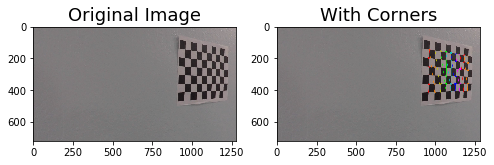

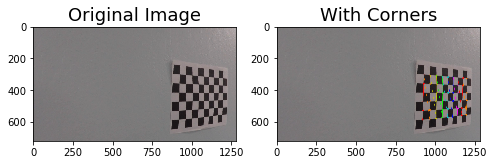

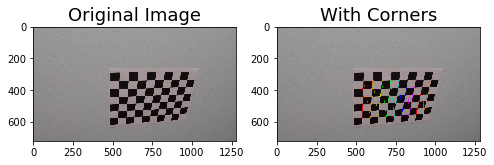

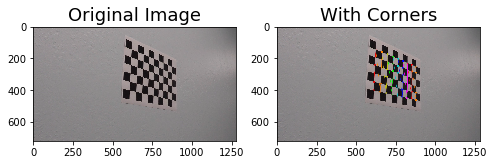

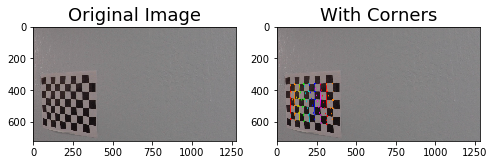

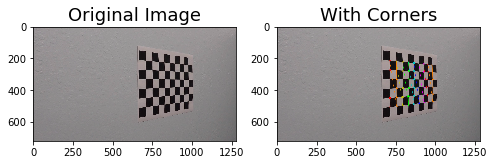

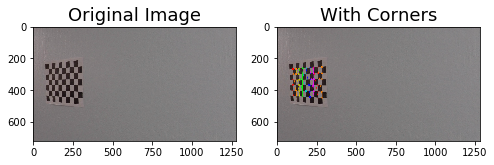

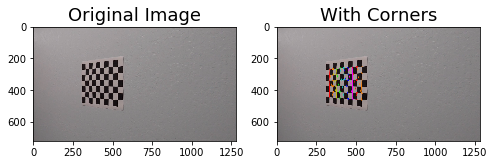

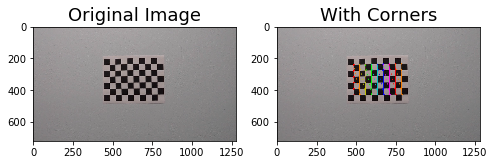

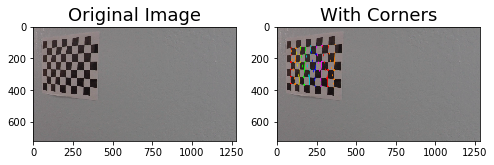

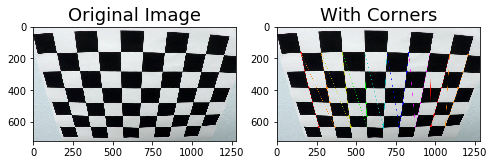

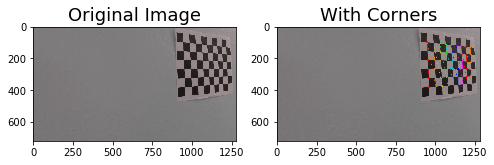

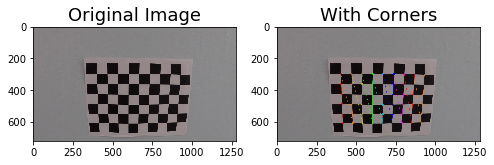

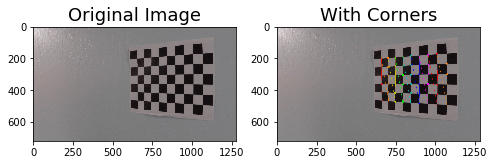

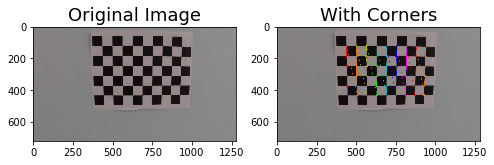

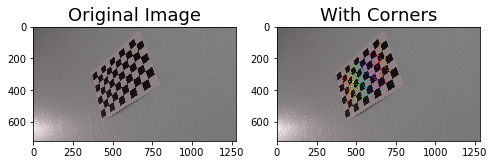

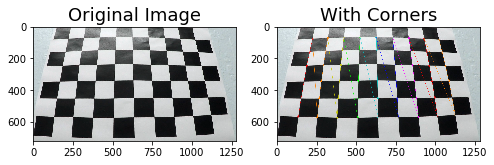

In [7]:
calibration = camera_calibrate('camera_cal', (9, 6), display=True)

## 2 -- Distortion Correction

function undistort() which uses the calculate camera calibration matrix and distortion coefficients to remove distortion from an image and output the undistorted image.

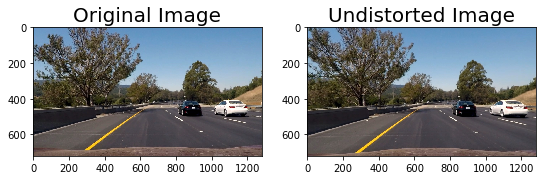

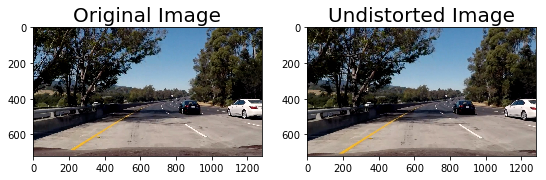

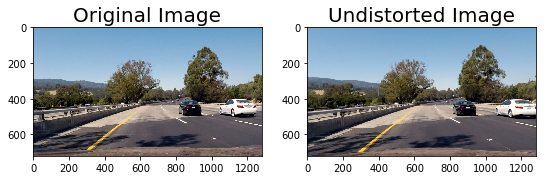

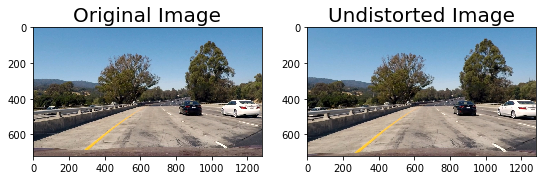

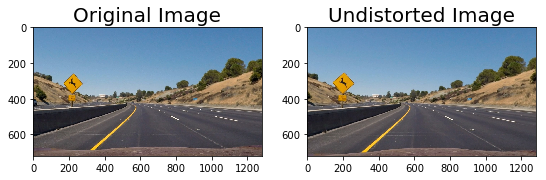

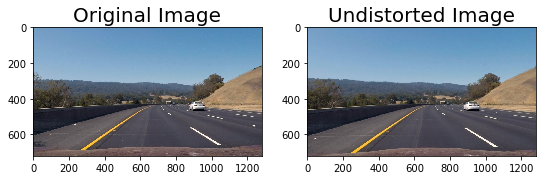

In [34]:
images = glob('test_images/test*.jpg')
for image in images:
    img = cv2.imread(image)
    undistort(img, calibration, display = True)

## 3 -- Color Transforms, Gradients and Thresholding

In this step, I used a combination of color and gradient thresholds to generate a binary image mask that can be used to extract lane pixels from a given video frame. It combines various techniques like sobel operations, color transforms, gradients, color extraction and noise reduction to generate an image mask. Through a lot of trial and error, various thresholds are chosen. 

Following is a brief description of each sub-step in order of execution:

* __Color Channel Selection__ :: An averaged gray scale image from the U and V color channels of the YUV space and also the S channel of the HLS space is used as input. Through some experimentation these channels were found to have brighter and clearer lane edges.

* __Sobel Operation__ :: This detects edges by computing approximate gradient of the image intensity function. It is applied in both x and y directions and combined to keep pixels that appear in both results and over certain threshold.

* __Gradient Magnitude & Direction__ :: The magnitude and direction of the gradient is calculated and combined by keeping only pixels within respective thresholds.

* __Color Isolation_ :: Through basic color thresholding yellow lane pixels are isolated.

* __High Intensity Detection__ :: In order to make process more resilient against different lighting conditions, all the pixels which have values above a given percentile are isolated.

* __Noise Reduction__ :: Used a 2d filter to reduce the noise in the image. 

In the end, the results are combined through a bitwise OR operation to get the final lane mask.

In [3]:
def display2(img1, img2, title1, title2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
    ax1.imshow(img1)
    ax1.set_title(title1, fontsize=18)
    ax2.imshow(img2)
    ax2.set_title(title2, fontsize=18)

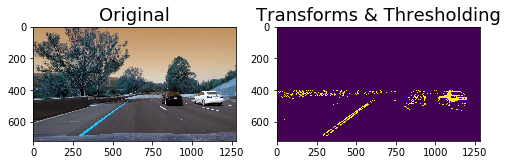

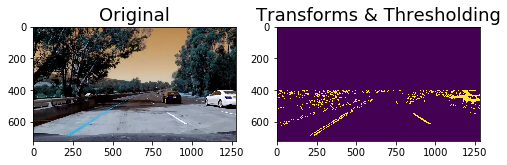

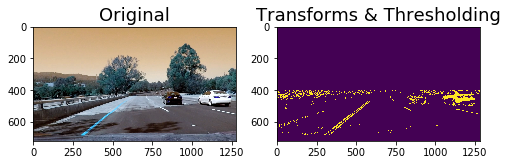

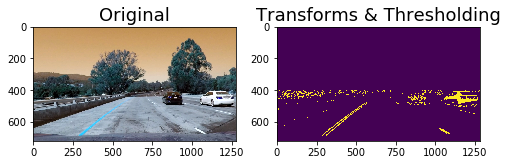

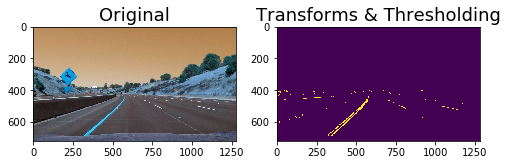

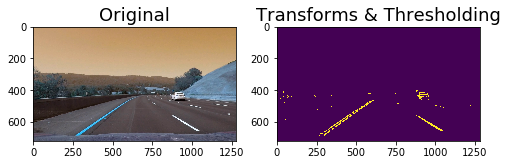

In [11]:
images = glob('test_images/test*.jpg')
for image in images:
    img = cv2.imread(image)
    img1 = get_thresholded_img(img, 400)
    display2(img,img1,'Original','Transforms & Thresholding')

## 4 -- Perspective Transform or Birds Eye Transform

In this step, I will describe the functionality of Perspective Transform, which transforms the undistorted image to a __"birds eye view"__ of the road which focuses only on the lane lines and displays them in such a way that they appear to be relatively parallel to eachother. This will make it easier later on to fit polynomials to the lane lines and measure the curvature.

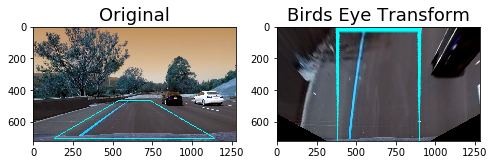

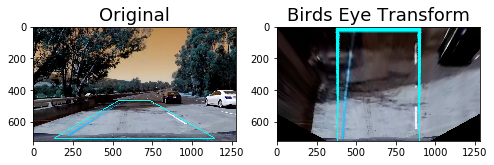

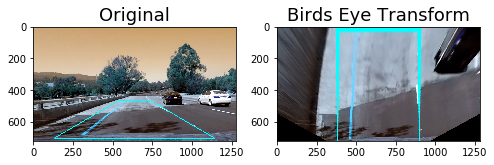

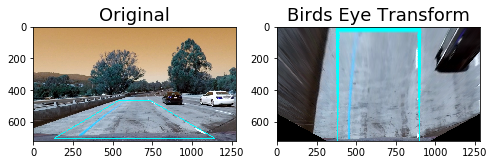

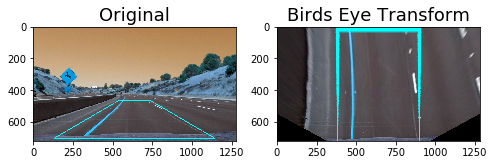

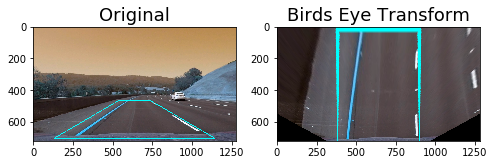

In [10]:
images = glob('test_images/test*.jpg')
for image in images:
    img = cv2.imread(image)
    src, dst, ROI= get_birds_eye_ROI(img)
    a = tuple(src[0])
    b = tuple(src[1])
    c = tuple(src[2])
    d = tuple(src[3])
    color=[0, 255, 255]
    thickness=3
    cv2.line(img, a, b, color, thickness)
    cv2.line(img, b, c, color, thickness)
    cv2.line(img, c, d, color, thickness)
    cv2.line(img, d, a, color, thickness)
        
    M = cv2.getPerspectiveTransform(src,dst)
    img1 = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    display2(img, img1, 'Original', 'Birds Eye Transform')


## 5 -- Pixel Histogram Analysis

Not all pixels that appear in the binary mask belong to lanes. There is still lot of noise in the mask. In order to identify the lane pixels, a sliding window technique as described by Cezanne is applied. The highest peak of each histogram is used as the center of a window which assigns every pixel inside it to the corresponding lane. This process is applied to the left half of the image to detect left lane pixels and then repeated on the right half of the image to detect right lane pixels. 

The process described above is bit slow to apply to each and every frame of the video. As an optimization, algorithm tries to find lane pixels in subsequent frame along the previously found lines first. 

## 6 -- Polynomial Fitting

Once all the pixel coordinates (x, y) have been assigned to respective lanes, a second order polynomial is fitted. This is our line of detected lanes. For smoother results, polynomials are averaged over last few frames. This polynomial is also used to calculate the radius of curvature of the lane and car's offset from the center of the lane.

## 7 -- Overlay & Inverse Transformation -- Last Step !

In this last step, I overlay the computed polynomial lane area in Green and Lanes itself in Yellow. Then we unwarp the processed image to its original perspective. And add the Curvature and distance to center as overlay.

/home/admin1/anaconda3/envs/keras/lib/python3.5/site-packages/scipy/signal/_peak_finding.py:412: RuntimeWarning: divide by zero encountered in double_scalars
  snr = abs(cwt[line[0][0], line[1][0]] / noises[line[1][0]])
/home/admin1/anaconda3/envs/keras/lib/python3.5/site-packages/scipy/signal/_peak_finding.py:412: RuntimeWarning: invalid value encountered in double_scalars
  snr = abs(cwt[line[0][0], line[1][0]] / noises[line[1][0]])
/home/admin1/src/sanjay/CarND-Advanced-Lane-Lines/P4_lanes.py:238: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  window = img[y_center - half_size:y_center + half_size, x_center - half_size:x_center + half_size]


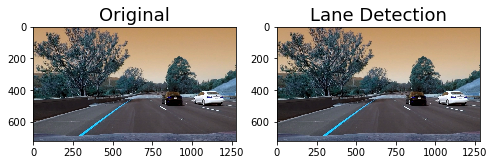

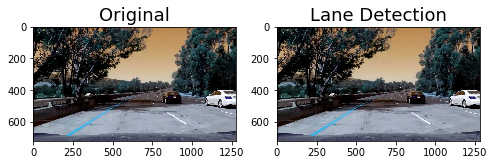

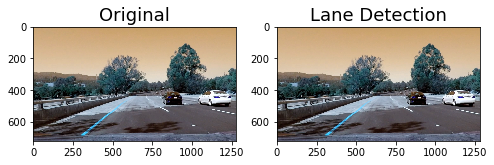

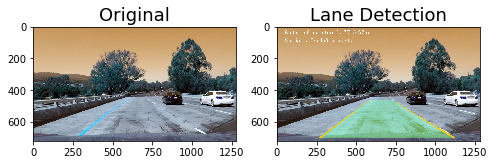

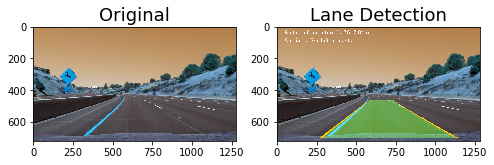

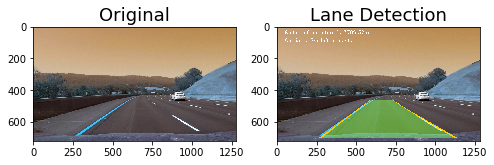

In [4]:
images = glob('test_images/test*.jpg')
lane_process = LaneProcess()
for image in images:
    img = cv2.imread(image)
    img1 = lane_process.process_image(img)
    display2(img, img1, 'Original', 'Lane Detection')

## Analysis & Conclusion

This was an __intensely coding__ oriented project. Although the steps were taught in the lecture, actually performing those steps and verifying they work as expected was challenging

Histogram Analysis & Polynomial fitting were the most challenging as that involved understand of several new concepts, and getting it right. It involved a lot of trial and error in finding the right thresholds to make the pipeline work. 

Overall, I'm satisfied with the results, and can verify that model identifies the lanes correctly. When the abnormal lanes that is way different from the previous lanes are detected from the model, validation function detects this abnormality and restarts detection process.

Although, this mechanical approach finally worked out for first two videos, this approach seems little fragile, and needs to battle tested. The harder_challenge_video is an example where this approach does not fit the bill. Perhaps a deep Learning Neural Network based approach with RNN/LSTM might be useful approaches. 




<a id='Results_Cell'></a>

# Results

In [1]:
from IPython.display import HTML
from P4_lanes import *
%matplotlib inline

In [2]:
from moviepy.video.io.VideoFileClip import VideoFileClip
videos = ["project_video.mp4", "challenge_video.mp4", "harder_challenge_video.mp4"]

for video in videos:
    lane_process = LaneProcess()
    video_clip = VideoFileClip(video)
    processed_clip = video_clip.fl_image(lane_process.process_image)
    processed_clip.write_videofile(video[:-4] + '_with_lanes.mp4', audio=False)


[MoviePy] >>>> Building video project_video_with_lanes.mp4
[MoviePy] Writing video project_video_with_lanes.mp4


100%|█████████▉| 1260/1261 [13:03<00:00,  1.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_with_lanes.mp4 

[MoviePy] >>>> Building video challenge_video_with_lanes.mp4
[MoviePy] Writing video challenge_video_with_lanes.mp4


100%|██████████| 485/485 [04:38<00:00,  1.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_with_lanes.mp4 

[MoviePy] >>>> Building video harder_challenge_video_with_lanes.mp4
[MoviePy] Writing video harder_challenge_video_with_lanes.mp4


100%|█████████▉| 1199/1200 [22:23<00:01,  1.25s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_with_lanes.mp4 



In [3]:
%%HTML
<table><thead>
<tr>
<th align="center">Project Track</th>
<th align="center">Challenge Track</th>
<th align="center">Harder Challenge Track</th>
</tr>
</thead><tbody>
<tr>
<td align="center"><video width="320" height="240" controls> <source src="project_video_with_lanes.mp4" type="video/mp4"> </video></td>
<td align="center"><video width="320" height="240" controls> <source src="challenge_video_with_lanes.mp4" type="video/mp4"> </video></td>
<td align="center"><video width="320" height="240" controls> <source src="harder_challenge_video_with_lanes.mp4" type="video/mp4"> </video></td>
</tr>
</tbody></table>

Project Track,Challenge Track,Harder Challenge Track
,,
